## Pricing Test Goal 

Pricing optimization is, non surprisingly, another area where data science can provide huge value. The goal here is to evaluate whether a pricing test running on the site has been successful. As always, you should focus on user segmentation and provide insights about segments who behave differently as well as any other insights you might find.

## Challenge Description

Company XYZ sells a software for $39. Since revenue has been flat for some time, the VP of Product has decided to run a test increasing the price. She hopes that this would increase revenue. In the experiment, 66 percent of the users have seen the old price (39), while a random sample of 33 percent users a higher price (59). 

The test has been running for some time and the VP of Product is interested in understanding how it went and whether it would make sense to increase the price for all the users. Especially he asked you the following questions: 

Should the company sell its software for $39 or $59? The VP of Product is interested in having a holistic view into user behavior, especially focusing on actionable insights that might increase conversion rate. What are your main findings looking at the data? 

### Bonus
The VP of Product feels that the test has been running for too long and he should have been able to get statistically significant results in a shorter time. Do you agree with her intuition? After how many days you would have stopped the test? Please, explain why. 


# Findings
- Higher price group has a lower conversion rate (1.6 percent), compared to lower price group (2 percent). But, the revene generated per user for the higher price group is statistically significantly higher. Avg revenue for treatment group: 0.92 vs 0.78

- Logistic regression result indicates that lower price, sources (esp. ads and friend referral, and seo-google), and users that use ISO operative system are more highly to convert. 

- We can run experiment for 2 weeks to collect a sample size of 46200 to have a statistically significnat difference of 0.2% in conversion rate. (95% confidence level)



# 1. Data Cleaning

In [159]:
#import packages
import pandas as pd
import math
import statsmodels.stats as sm
import scipy.stats as st

In [3]:
test = pd.read_csv('test_results.csv')
user = pd.read_csv('user_table.csv')

In [4]:
print(test.shape)
test.head()

(316800, 8)


,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
user_id             316800 non-null int64
timestamp           316800 non-null object
source              316800 non-null object
device              316800 non-null object
operative_system    316800 non-null object
test                316800 non-null int64
price               316800 non-null int64
converted           316800 non-null int64
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


In [10]:
test.describe()

,user_id,test,price,converted
count,316800.000000,316800.000000,316800.000000,316800.000000
mean,499281.341840,0.360079,46.205051,0.018333
std,288591.154044,0.480024,9.601487,0.134154
min,3.000000,0.000000,39.000000,0.000000
25%,249525.750000,0.000000,39.000000,0.000000
50%,499021.500000,0.000000,39.000000,0.000000
75%,749025.500000,1.000000,59.000000,0.000000
max,1000000.000000,1.000000,59.000000,1.000000


In [35]:
# sanity check
print(test.test.value_counts())
print(test.price.value_counts())

0    202727
1    114073
Name: test, dtype: int64
39    202672
59    114128
Name: price, dtype: int64


The numbers does not match. There are some experiment contamination. Users in control group (202727) does not match  their price counts (202672)

In [112]:
# check these disprecency rows
wrong_control = test.loc[(test['test']==0) & (test['price']!=39)]
print(wrong_control.shape)
wrong_control.head()

(210, 8)


,user_id,timestamp,source,device,operative_system,test,price,converted
8238,500863,2015-05-06 22:40:51,ads_other,mobile,iOS,0,59,0
8369,791541,2015-04-13 10:24:19,ads-bing,web,windows,0,59,0
11555,402699,2015-05-16 12:08:45,direct_traffic,mobile,other,0,59,0
12848,624380,2015-05-22 12:37:19,seo-google,mobile,iOS,0,59,0
14630,577544,2015-04-24 17:44:57,seo-google,mobile,android,0,59,0


In [113]:
# check these disprecency rows
wrong_treatment = test.loc[(test['test']==1) & (test['price']!=59)]
print(wrong_treatment.shape)
wrong_treatment.head()

(155, 8)


,user_id,timestamp,source,device,operative_system,test,price,converted
1457,686486,2015-03-28 15:26:19,seo-other,mobile,android,1,39,0
1912,128338,2015-05-15 11:41:49,direct_traffic,mobile,android,1,39,0
2337,220590,2015-03-27 12:31:43,ads-google,web,windows,1,39,0
3147,246390,2015-05-30 08:29:44,direct_traffic,mobile,iOS,1,39,0
4277,906451,2015-04-05 11:09:18,ads-google,web,windows,1,39,0


In [114]:
# drop these rows
clean_test = test.drop(wrong_control.index)
clean_test = clean_test.drop(wrong_treatment.index)
print(clean_test.shape)

(316435, 8)


In [115]:
# check if users are counted only once
clean_test.user_id.nunique()

316435

In [116]:
# now let's check the percentage again
print(round(clean_test.test.sum()/clean_test.shape[0]*100,3), '% users in higher price group')
print(100- round(clean_test.test.sum()/clean_test.shape[0]*100,3), '% users in old price group')


36.0 % users in higher price group
64.0 % users in old price group


In [117]:
# check experimental range
clean_test['timestamp'] = clean_test['timestamp'].apply(lambda x:x[:10])
clean_test['timestamp'] =  pd.to_datetime(clean_test['timestamp'], format='%Y-%m-%d')


In [118]:
print(clean_test.timestamp.min())
print(clean_test.timestamp.max())

# 3 months of experiment

2015-03-02 00:00:00
2015-05-31 00:00:00


In [ ]:
clean_test['revenue'] = clean_test['price']*clean_test['converted']

# 1.2 Exploratory Data Analysis


In [245]:
# how conversition rate differ by group
test_grp = clean_test.groupby(by=['test'],as_index=False)
test_grp.agg({'converted':'mean','revenue':'mean'})

,test,converted,revenue
0,0,0.019900,0.776083
1,1,0.015555,0.917748


In [247]:
# how conversition rate differ by device
device_grp = clean_test.groupby(by=['device', 'test'],as_index=False)
device_grp = device_grp.agg({'converted':'mean','revenue':'mean'})
device_grp

,device,test,converted,revenue
0,mobile,0,0.019872,0.775017
1,mobile,1,0.016146,0.952624
2,web,0,0.019940,0.777645
3,web,1,0.014744,0.869888


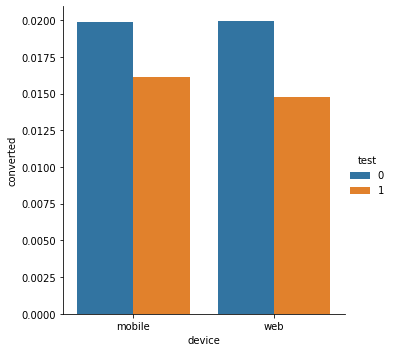

In [261]:
sns.catplot(x="device", y='converted', hue="test", kind='bar', 
                   data=device_grp)

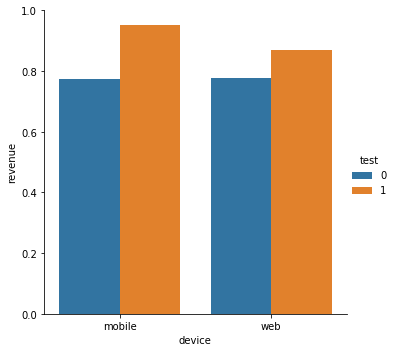

In [250]:
sns.catplot(x="device", y="converted", hue="test", kind="bar", data=device_grp,ax=ax)

In [262]:
# how conversition rate differ by source
source_grp = clean_test.groupby(by=['source', 'test'],as_index=False)
source_grp = source_grp.agg({'converted':'mean','revenue':'mean'})
source_grp

,source,test,converted,revenue
0,ads-bing,0,0.013371,0.521462
1,ads-bing,1,0.009579,0.565175
2,ads-google,0,0.022566,0.880063
3,ads-google,1,0.019631,1.158208
4,ads-yahoo,0,0.016833,0.656484
5,ads-yahoo,1,0.011236,0.662921
6,ads_facebook,0,0.023654,0.922522
7,ads_facebook,1,0.016856,0.994502
8,ads_other,0,0.015424,0.601527
9,ads_other,1,0.012394,0.731220


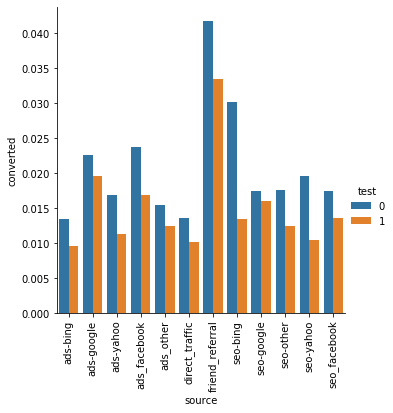

In [279]:
sns.catplot(x="source", y='converted', hue="test", kind='bar', 
                   data=source_grp)
plt.xticks(rotation=90)
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

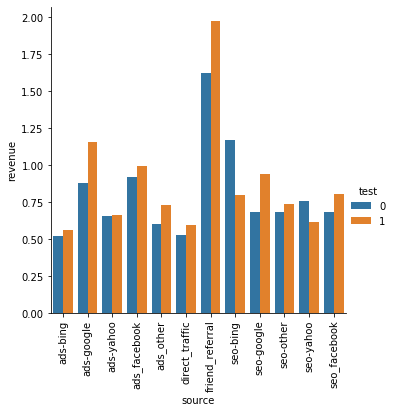

In [280]:
sns.catplot(x="source", y='revenue', hue="test", kind='bar', 
                   data=source_grp)
plt.xticks(rotation=90)

friend_referral has a higher conversion rate.

friend_referal, ads from google, seo-google has much higher revenue per user



In [285]:
# how conversition rate differ by operating system
operative_system_grp = clean_test.groupby(by=['operative_system', 'test'],as_index=False)
operative_system_grp = operative_system_grp.agg({'converted':'mean','revenue':'mean'})
operative_system_grp

,operative_system,test,converted,revenue
0,android,0,0.016336,0.637088
1,android,1,0.012363,0.729405
2,iOS,0,0.023595,0.920201
3,iOS,1,0.019994,1.179648
4,linux,0,0.015426,0.601633
5,linux,1,0.000000,0.000000
6,mac,0,0.025451,0.992597
7,mac,1,0.021240,1.253157
8,other,0,0.014025,0.546990
9,other,1,0.011060,0.652563


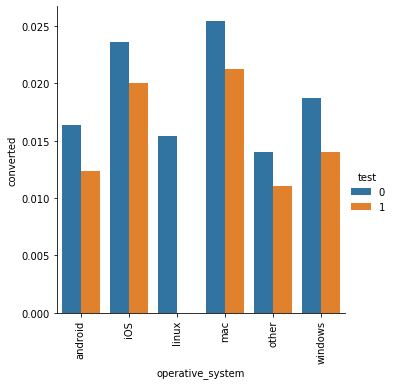

In [286]:
sns.catplot(x="operative_system", y='converted', hue="test", kind='bar', 
                   data=operative_system_grp)
plt.xticks(rotation=90)
plt.show()

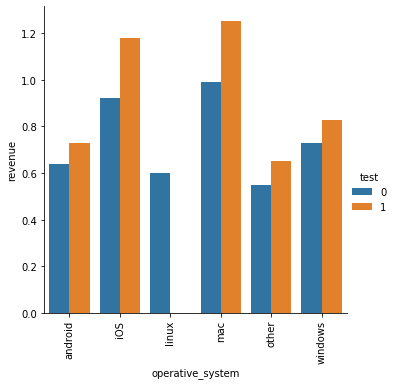

In [287]:
sns.catplot(x="operative_system", y='revenue', hue="test", kind='bar', 
                   data=operative_system_grp)
plt.xticks(rotation=90)
plt.show()

Mac and ISO have high conversion rate and average revenue

# 2. A/B Testing

### 2.1 Hypotheses testing for conversion rate

A/B test was performed under the assumption that the old price has the same conversion rate than the new price, unless the new price proves to definitely yield a larger convert rate at a Type I error rate of 5%. Based on this assumption,

$$H_0: p_{new} = p_{old} $$
$$H_1: p_{new} != p_{old}$$


### Two sample Z test

We compare two groups, and conversion rate a binary. So I use the formula
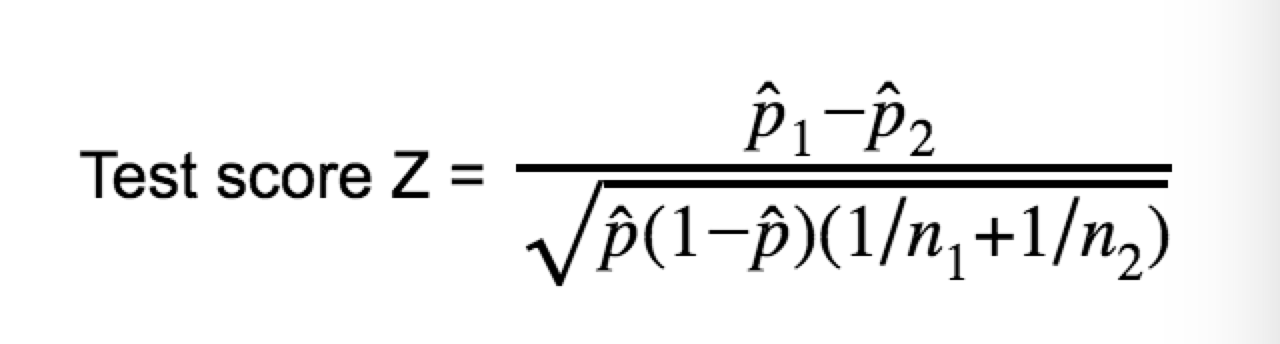


In [197]:
convert_old = clean_test.query('test == 0 and converted == 1').user_id.size
convert_new = clean_test.query('test == 1 and converted == 1').user_id.size
n_old = clean_test.query('test == 0').user_id.size
n_new = clean_test.query('test == 1').user_id.size

convert_old, convert_new, n_old, n_new

(4030, 1772, 202517, 113918)

In [212]:
z_score, p_value = sm.proportion.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value 

(8.74375299250435, 2.2549214716059568e-18)

We reject the null, and conclude that low vs high price groups has a statistically different conversion rate. More specificly, higher price group has a lower conversion rate

### 2.2 Hypotheses testing for revenue

$$H_0: avg_revenue_{new} <= avg_revenue_{old} $$
$$H_1: avg_revenue_{new} > avg_revenue_{old} $$

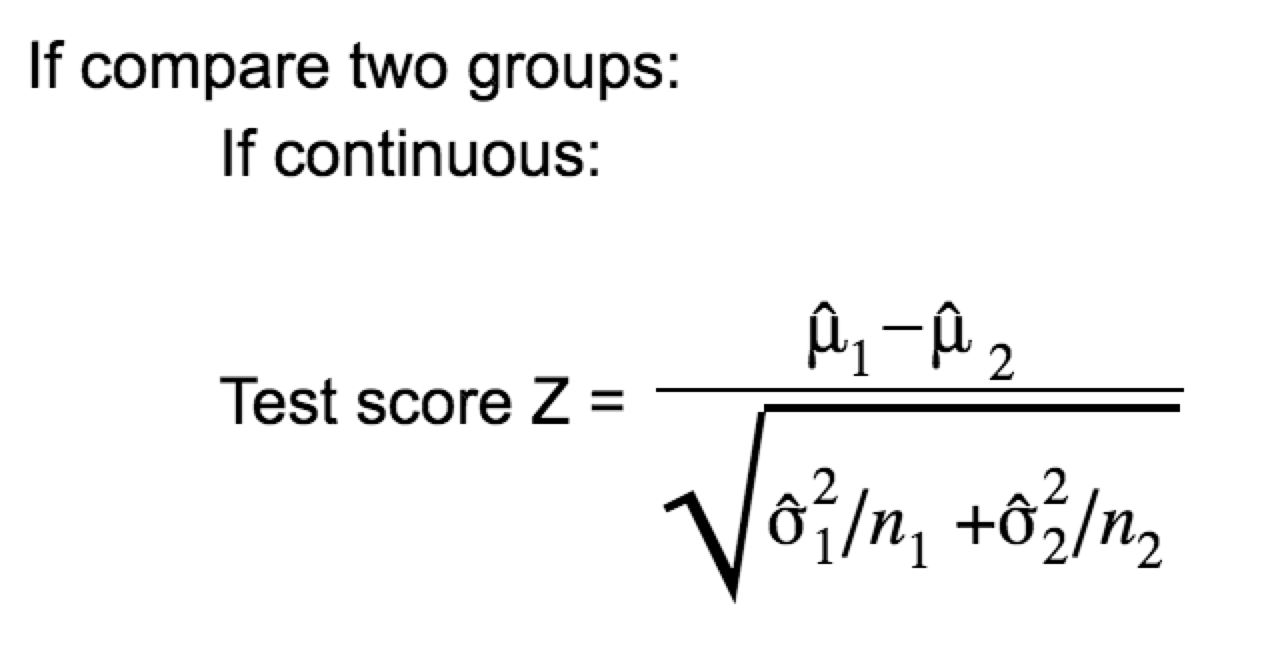


A two-sample z-test is used to test whether the means of the two populations are different from each other.

A two-sample t-test is used to test whether the means of the two populations are different from each other.

The difference between two sample t-test vs z-test is that t test assumes that the variances of the two population distributions are unknown, while z test assumes the variances of the two population distributions are known; also z test requires sample size >30

In [214]:
# calculate average revenue per group
revenue_old = clean_test.query('test == 0').revenue
revenue_new = clean_test.query('test == 1').revenue
n_old = clean_test.query('test == 0').user_id.size
n_new = clean_test.query('test == 1').user_id.size

revenue_new.mean(), revenue_old.mean(), n_new,n_old

(0.917747853719342, 0.7760829955016122, 113918, 202517)

In [222]:
# z test 
z_score, p_value = sm.weightstats.ztest(x1=revenue_new,x2=revenue_old,
                                        value=0, alternative='larger')
z_score, p_value 

(6.190896693515704, 2.9911454517807973e-10)

In [227]:
# t test 
t_score, p_value = st.ttest_ind(revenue_new,revenue_old )
t_score, p_value

(6.190896693515704, 5.989596053694189e-10)

In [228]:
# t test, uneual variance
t_score, p_value = st.ttest_ind(revenue_new,revenue_old,equal_var = False )
t_score, p_value

(5.715224666463108, 1.0972577312420781e-08)

All these tests reject the null, concluding that higher price does generate a higher revenue per user

# 3. Logistic Regression to examine factors affecting conversion rate

In [388]:
df = clean_test.copy()
print(df.shape)

(316435, 9)


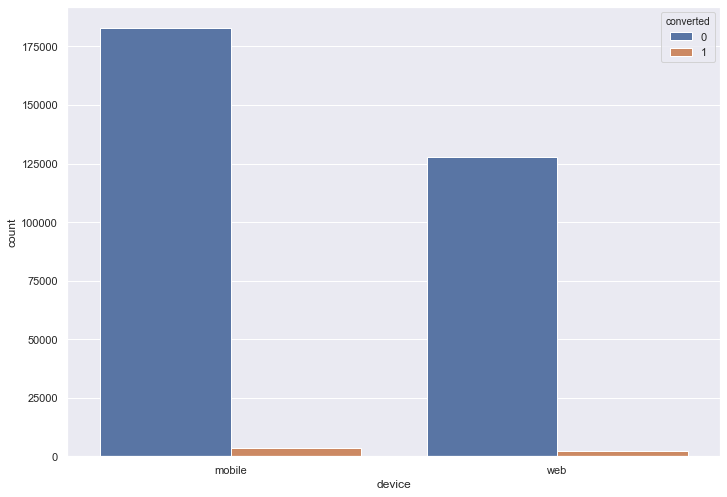

In [389]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.countplot(x='device', hue='converted',data=df)


In [390]:
# one hot encoding
cat_features = ['source','device','operative_system']
for cat in cat_features:
    df = pd.get_dummies(df, columns=[cat],drop_first = True)  #drop_first 避免collinearity

In [391]:
df.groupby('converted').mean()

,user_id,test,price,revenue,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,...,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_web,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
converted,,,,,,,,,,,,,,,,,,,,,
0,499243.375218,0.361024,46.220482,0.000000,0.186928,0.024012,0.168121,0.094639,0.191644,0.063992,...,0.073254,0.029292,0.021665,0.067098,0.411489,0.300110,0.013186,0.078723,0.051401,0.319152
1,502900.286970,0.305412,45.108239,45.108239,0.219924,0.019304,0.194933,0.073768,0.127715,0.137883,...,0.067735,0.024991,0.019131,0.058600,0.404343,0.366942,0.005860,0.103585,0.036194,0.294898


In [392]:
X = df.drop(['user_id','timestamp','test','converted','revenue'],axis=1)

In [393]:
# Get target variable
y = df['converted']

In [394]:
X.head()

,price,source_ads-google,source_ads-yahoo,source_ads_facebook,source_ads_other,source_direct_traffic,source_friend_referral,source_seo-bing,source_seo-google,source_seo-other,source_seo-yahoo,source_seo_facebook,device_web,operative_system_iOS,operative_system_linux,operative_system_mac,operative_system_other,operative_system_windows
0,39,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,39,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,59,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,39,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0


In [395]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.2,
                                                   random_state=4)



In [396]:
# statsmodel package
import statsmodels.api as sm

#statsmodels does not include an intercept, so need to add constant first
X = sm.add_constant(x_train)

logit_model=sm.Logit(y_train,X)
result=logit_model.fit()
result.summary()

         Current function value: 0.088970
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               253148
Model:                          Logit   Df Residuals:                   253129
Method:                           MLE   Df Model:                           18
Date:                Mon, 06 Jul 2020   Pseudo R-squ.:                 0.01642
Time:                        22:04:42   Log-Likelihood:                -22523.
converged:                      False   LL-Null:                       -22899.
Covariance Type:            nonrobust   LLR p-value:                4.955e-148
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -4.0320      0.105    -38.483      0.000      -4.237      -3.827
price                       -0.0131      0.002     -8.052      0.000      -0.016      -0.010
source_ads-google            0.5914      0.076      7.811      0.000       0.443       0.740
source_ads-yahoo             0.2790      0.125      2.231      0.026       0.034       0.524
source_ads_facebook          0.5979      0.076      7.826      0.000       0.448       0.748
source_ads_other             0.2312      0.087      2.656      0.008       0.061       0.402
source_direct_traffic        0.0348      0.080      0.434      0.664      -0.122       0.192
source_friend_referral       1.1743      0.080     14.672      0.000       1.017       1.331
source_seo-bing              0.6263      0.180      3.480      0.001       0.274       0.979
source_seo-google            0.3488      0.090      3.894      0.000       0.173       0.524
source_seo-other             0.2684      0.117      2.293      0.022       0.039       0.498
source_seo-yahoo             0.3002      0.129      2.334      0.020       0.048       0.552
source_seo_facebook          0.2896      0.093      3.127      0.002       0.108       0.471
device_web                 -12.4391    445.067     -0.028      0.978    -884.755     859.877
operative_system_iOS         0.4030      0.042      9.627      0.000       0.321       0.485
operative_system_linux      11.8279    445.067      0.027      0.979    -860.488     884.144
operative_system_mac        12.8991    445.067      0.029      0.977    -859.417     885.215
operative_system_other      -0.1447      0.086     -1.689      0.091      -0.313       0.023
operative_system_windows    12.5484    445.067      0.028      0.978    -859.768     884.865
============================================================================================
"""

Important faetures affecing conversion: 'price','source_ads-google', ,'source_ads_facebook',
'source_friend_referral', 'source_seo-google','operative_system_iOS','source_ads-yahoo', 'source_ads_other','source_seo-bing','source_seo-other','source_seo_facebook','source_seo-yahoo', 

# 4. How many days would I stop the test?

The power of a hypothesis test is the probability of making the correct decision if the alternative hypothesis is true

In [298]:
# baseline conversion rate  0.01834
baseline_cr = clean_test.converted.mean()
baseline_cr

0.01833551914295195

In [303]:
# calculate test power
def get_power(n, p1, p2, cl):
    alpha = 1 - cl
    qu = stats.norm.ppf(1 - alpha/2)
    diff = abs(p2-p1)
    bp = (p1+p2) / 2
    
    v1 = p1 * (1-p1)
    v2 = p2 * (1-p2)
    bv = bp * (1-bp)
    
    power_part_one = stats.norm.cdf((n**0.5 * diff - qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    power_part_two = 1 - stats.norm.cdf((n**0.5 * diff + qu * (2 * bv)**0.5) / (v1+v2) ** 0.5)
    
    power = power_part_one + power_part_two
    
    return (power)


In [332]:
# calcualte sample size per group needed for speficied power and confidence level
def get_sample_size(power,p1,p2,cl,max_n=1000000):
    n = 1
    while n <= max_n:
        tmp_power = get_power(n,p1,p2,cl)
        if tmp_power >= power:
            return n
        else:
            n = n+100

In [361]:
# percent lift
(0.0199-0.01555)/0.01555

0.279742765273312

In [364]:
conversion_rate = 0.01834
power = 0.8
cl = 0.95
percent_lift = 0.2
conversion_rate_p2 = conversion_rate * (1 + percent_lift)
get_sample_size(power, conversion_rate, conversion_rate_p2, cl)

23101

In [359]:
conversion_rate = 0.01834
power = 0.95
cl = 0.95
percent_lift = 0.2
conversion_rate_p2 = conversion_rate * (1 + percent_lift)
get_sample_size(power, conversion_rate, conversion_rate_p2, cl)

38201

In [342]:
# count number of users by date
daily_user_count = clean_test.groupby(by=['timestamp'],as_index=False)['user_id'].count()
daily_user_count.head()

,timestamp,user_id
0,2015-03-02,1589
1,2015-03-03,1496
2,2015-03-04,1413
3,2015-03-05,2813
4,2015-03-06,7200


In [343]:
daily_user_count['cumcount'] = daily_user_count.user_id.cumsum() 

In [365]:
daily_user_count[daily_user_count['cumcount']>=23101*2].head()

,timestamp,user_id,cumcount
13,2015-03-15,4060,48931
14,2015-03-16,1392,50323
15,2015-03-17,1528,51851
16,2015-03-18,1471,53322
17,2015-03-19,2807,56129


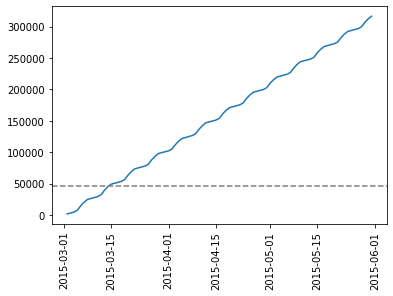

In [366]:
plt.plot(daily_user_count['timestamp'],daily_user_count['cumcount'])
plt.xticks(rotation=90)

plt.axhline(y=23101*2, color='grey', linestyle='--')


We can run experiment for 2 weeks to collect a sample size of 46200 to have a statistically significnat difference of 0.2% in conversion rate. (95% confidence level) 

In [347]:
from statsmodels.stats.power import zt_ind_solve_power
from statsmodels.stats.proportion import proportion_effectsize as es
zt_ind_solve_power(effect_size=es(prop1=0.0199,prop2=0.01555),
                   alpha=0.05,power=0.8,alternative='two-sided')


14389.725364311815

In [367]:
daily_user_count[daily_user_count['cumcount']>=14390*2].head()

,timestamp,user_id,cumcount
9,2015-03-11,1406,29074
10,2015-03-12,2895,31969
11,2015-03-13,7119,39088
12,2015-03-14,5783,44871
13,2015-03-15,4060,48931


In [ ]:
# a geography graph about user distribution 
